# Gradient Descent 

In [13]:
import logging 
import numpy as np 
import pandas as pd

import algo_ecg.data
import algo_ecg.preprocessing
from algo_ecg.feature_transformer import \
calculate_hrv_based_on_peak_intervals3, \
FindPeaksCustomTransformer, select_cols

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

import seaborn as sns

Sigmoid function 
$$f(x) = \frac{1}{1 + e^{-(x)}}$$

In [2]:
def sigmoid(z):
    denom = 1+np.e**(0-z)
    return 1/denom

Cost function 
$$J(\theta) = -\frac{1}{m}\sum[y^{(i)}log(h\theta(x^{(i)})) + (1-y^{(i)})log(1-h\theta(x^{(i)}))]$$

Partial derivative
$$\frac{\partial}{\partial\theta}J(\theta) = \frac{1}{m}\sum(h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}$$

In [3]:
def cost_function(theta, X, y):
    m=np.size(y)  # number of training samples
    
    h_theta_x = sigmoid(np.dot(X,theta))
    term1 = (0-y)*np.log(h_theta_x)
    term2 = (1-y)*np.log(1-h_theta_x)
    J = (np.sum(term1-term2))/m
    
    grad = np.dot(np.transpose(h_theta_x - y),X)
    grad = grad/m
    
    return (J, grad)

Parameter update via gradient descent: 
$$\theta_{j} := \theta_{j} - \alpha (\frac{1}{m} \sum \limits_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)})$$

In [4]:
def gradient_descent(X, y, theta,
                    alpha=0.01, num_iterations=1500):
    """
    Solve for theta using Gradient Descent optimiztion technique. 
    Alpha is the learning rate
    """
    m = len(y)
    J_history = []
    theta0_history = []
    theta1_history = []
    theta2_history = []
    theta = theta.reshape(3,1)

    for i in range(num_iterations):
        error = (np.dot(X, theta) - y)
        
        term0 = (alpha/m) * np.sum(error* X[:,0].reshape(m,1))
        term1 = (alpha/m) * np.sum(error* X[:,1].reshape(m,1))
        term2 = (alpha/m) * np.sum(error* X[:,2].reshape(m,1))
        
        # update theta
        term_vector = np.array([[term0],[term1], [term2]])
#         print(term_vector)
        theta = theta - term_vector.reshape(3,1)
        
        # store history values
        theta0_history.append(theta[0].tolist()[0])
        theta1_history.append(theta[1].tolist()[0])
        theta2_history.append(theta[2].tolist()[0])
        J_history.append(cost_function(theta,X,y)[0])

    return (theta, J_history, theta0_history, theta1_history, theta2_history)

# Load data and run

In [5]:
X_in, y, pids = algo_ecg.data.import_physionet_data('/Users/jessie/data/PhysioNet_CinC', num_files_to_read=1000)
X, pids = algo_ecg.preprocessing.preprocess_pid(X_in, pids)
slice_length = len(X[0])
X = np.concatenate(X).reshape(-1, slice_length, 1)
X = pd.DataFrame.from_records(X)

In [8]:
pipe = Pipeline(steps=[
    ('peaks', FindPeaksCustomTransformer (axis=1)), 
    ('feature_select_manual',FunctionTransformer(select_cols, kw_args={"col_names": ['RMSSD_ms','pNN50']})),
    ('standardscaler', StandardScaler())
])


In [9]:
X_df = pipe.fit_transform(X)

In [10]:
X_df2 = pd.DataFrame.from_records(X_df)

In [11]:
X_df2.head(2)

,0,1
0,-0.865775,-0.829206
1,1.869359,0.814616


In [29]:
X_df

array([[-0.86577515, -0.82920565],
       [ 1.86935931,  0.81461551],
       [-0.99278042, -0.82920565],
       ...,
       [ 0.76672786,  1.0688941 ],
       [-0.39416386, -0.76149143],
       [-0.63272357, -0.48829956]])

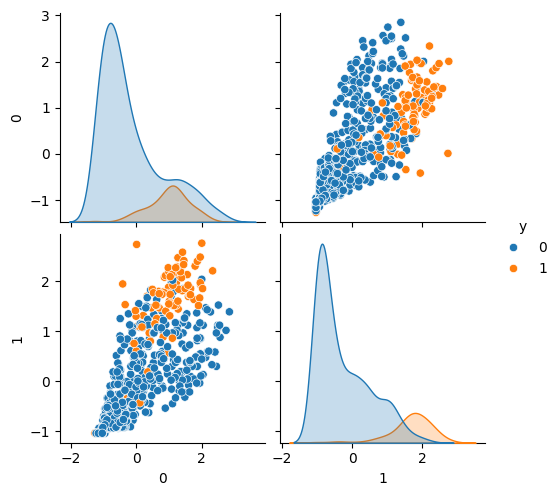

In [14]:
X_df2['y'] = y
sns.pairplot(X_df2, hue = "y")

In [15]:
x_0 = np.ones(X_df.shape[0]).reshape(X_df.shape[0],1)
#x_0

In [16]:
X2 = np.concatenate((x_0, X_df), axis=1)
X2.shape

(690, 3)

In [17]:
X_df.shape

(690, 2)

In [18]:
initial_theta = np.zeros(X_df.shape[1]+1).reshape(X_df.shape[1]+1,1)
initial_theta.reshape(3,1)

array([[0.],
       [0.],
       [0.]])

In [19]:
initial_theta2 = (np.ones(3)-0.5).reshape(3,1)
initial_theta2.reshape(3,1)

array([[0.5],
       [0.5],
       [0.5]])

In [20]:
# compute cost and gradient
(J, grad) = cost_function(initial_theta, X2, y)
print(f'Cost at initial theta: {J}')
print(f'Gradient at inital theta: {grad.flatten()}')

Cost at initial theta: 478.271554586362
Gradient at inital theta: [ 5.00000000e-01 -4.89141738e-17 -2.57443020e-18 ...  5.00000000e-01
 -4.89141738e-17  5.14886040e-18]


In [62]:
%%time
num_iterations=50
alpha=0.0002
theta, J_history, theta0_history, \
theta1_history, theta2_history = gradient_descent(X2,y,initial_theta2,
                                                  alpha,num_iterations)

CPU times: user 681 ms, sys: 992 ms, total: 1.67 s
Wall time: 166 ms


In [63]:
len(theta1_history)

50

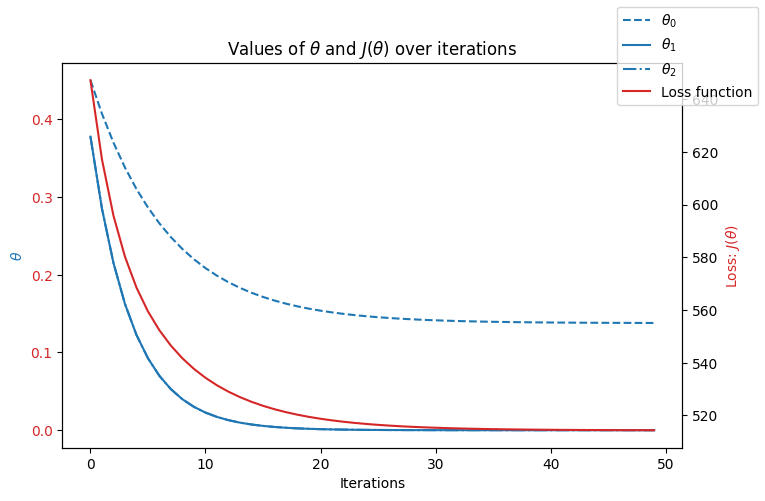

In [64]:
fig, ax1 = plt.subplots(figsize=(8,5))

# plot thetas over time
color='tab:blue'
ax1.plot(theta0_history, label='$\\theta_{0}$', linestyle='--', color=color)
ax1.plot(theta1_history, label='$\\theta_{1}$', linestyle='-', color=color)
ax1.plot(theta2_history, label='$\\theta_{2}$', linestyle='-.', color=color)
# ax1.legend()
ax1.set_xlabel('Iterations'); ax1.set_ylabel('$\\theta$', color=color);
ax1.tick_params(axis='y', labelcolor=color)

# plot loss function over time
color='tab:red'
ax2 = ax1.twinx()
ax2.plot(J_history, label='Loss function', color=color)
ax2.set_title('Values of $\\theta$ and $J(\\theta)$ over iterations')
ax2.set_ylabel('Loss: $J(\\theta)$', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# ax2.legend();
fig.legend();

In [65]:
# Decision boundary

In [66]:
from sklearn.linear_model import LogisticRegression
X = X_df
clf = LogisticRegression(random_state=0).fit(X, y)

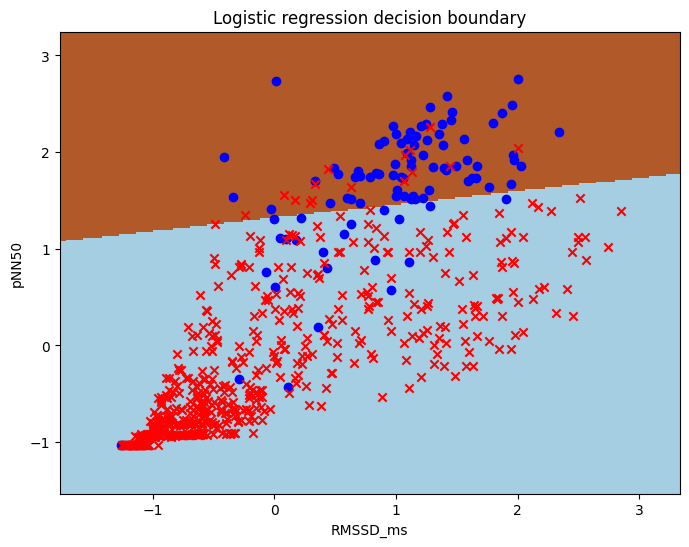

In [67]:
pos = np.where(y == 1)
neg = np.where(y == 0)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
# plt.scatter(X[:, 0], X[:, 1], edgecolors='k', cmap=plt.cm.Paired)
plt.scatter(X[pos, 0], X[pos, 1], marker='o', c='b')
plt.scatter(X[neg, 0], X[neg, 1], marker='x', c='r')
plt.xlabel('RMSSD_ms')
plt.ylabel('pNN50')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Logistic regression decision boundary');